In [4]:
import os
import numpy as np
import sys

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from  tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow.keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

import matplotlib.pyplot as plt

import cv2

from sklearn.metrics import accuracy_score

In [5]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)
X = np.load("/content/drive/MyDrive/Collab/DMPA Project/X.npy")
y = np.load("/content/drive/MyDrive/Collab/DMPA Project/y.npy")

In [6]:
newX = []
for i in X:
  newX.append(cv2.resize(i, (299, 299)))

newX = np.array(newX)
newX = np.repeat(newX[..., np.newaxis], 3, -1)
y = np.expand_dims(y,axis=1)

In [7]:
X=None

In [8]:
X_train, X_val, y_train, y_val = train_test_split(newX,y,test_size = 0.2,random_state = 0)
X_val, X_test, y_val, y_test = train_test_split(X_val,y_val,test_size = 0.5,random_state = 0)

y_train = to_categorical(y_train, 3)
y_val = to_categorical(y_val, 3)
y_test = to_categorical(y_test, 3)

In [9]:
y=None
newX=None

In [10]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(2451, 299, 299, 3) (2451, 3)
(306, 299, 299, 3) (306, 3)
(307, 299, 299, 3) (307, 3)


In [11]:
train_generator = ImageDataGenerator(rotation_range=180, horizontal_flip=True, shear_range=0.2, zoom_range=.5)
val_generator = ImageDataGenerator(rescale=1./1.)
test_generator = ImageDataGenerator(rescale=1./1.)

train_generator.fit(X_train) 
val_generator.fit(X_val)
test_generator.fit(X_test)

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import TensorBoard

inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)


predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)

model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

tb = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True)

batch_size = 32

history = model.fit(train_generator.flow(X_train, y_train, batch_size = batch_size),
                     epochs = 11, 
                     steps_per_epoch = X_train.shape[0]//batch_size,
                     validation_data = val_generator.flow(X_val, y_val, batch_size = batch_size), 
                     validation_steps = X_val.shape[0]//batch_size, 
                     callbacks=[tb],
                     verbose = 1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/11
76/76 [==============================] - 111s 1s/step - loss: 1.0800 - accuracy: 0.4766 - val_loss: 1.0663 - val_accuracy: 0.4931
Epoch 2/11
76/76 [==============================] - 100s 1s/step - loss: 0.8919 - accuracy: 0.6428 - val_loss: 0.9485 - val_accuracy: 0.5417
Epoch 3/11
76/76 [==============================] - 101s 1s/step - loss: 0.7575 - accuracy: 0.7094 - val_loss: 0.8179 - val_accuracy: 0.6424
Epoch 4/11
76/76 [==============================] - 101s 1s/step - loss: 0.6360 - accuracy: 0.7635 - val_loss: 0.6867 - val_accuracy: 0.7326
Epoch 5/11
76/76 [==============================] - 101s 1s/step - loss: 0.5517 - accuracy: 0.8090 - val_loss: 0.5878 - val_accuracy: 0.7917
Epoch 6/11
76/76 [==============================] - 99s 1s/step - loss: 0.5102 - accuracy: 0.8119 - val_loss: 0.5561 - val_accuracy: 0.7882
Epoch 7/11
76/76 [==============================] - 101s 1s/step - loss: 0.4730 - accuracy: 0.8198 - val_loss: 0.4913 - val_accuracy: 0.8194
Epoch 8/11
76/

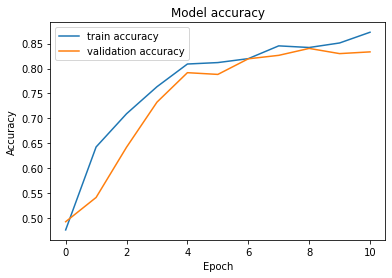

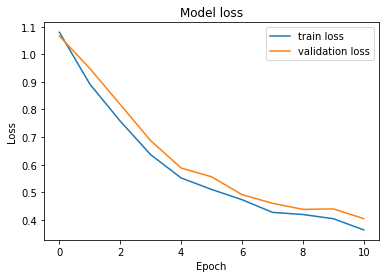

In [ ]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Accuracy_v1_InceptionV3')
    plt.show()
    
def plot_loss(history):
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.savefig('Loss_v1_InceptionV3')
    plt.show()
    
plot_accuracy(history)
plot_loss(history)

In [ ]:
y_pred = model.predict(X_val, verbose=1)
accuracy_score(np.argmax(y_val, axis=1),np.argmax(y_pred, axis=1))

10/10 [==============================] - 7s 777ms/step


0.8300653594771242

In [ ]:
y_pred = model.predict(X_test, verbose=1)
accuracy_score(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))

10/10 [==============================] - 3s 358ms/step


0.8697068403908795

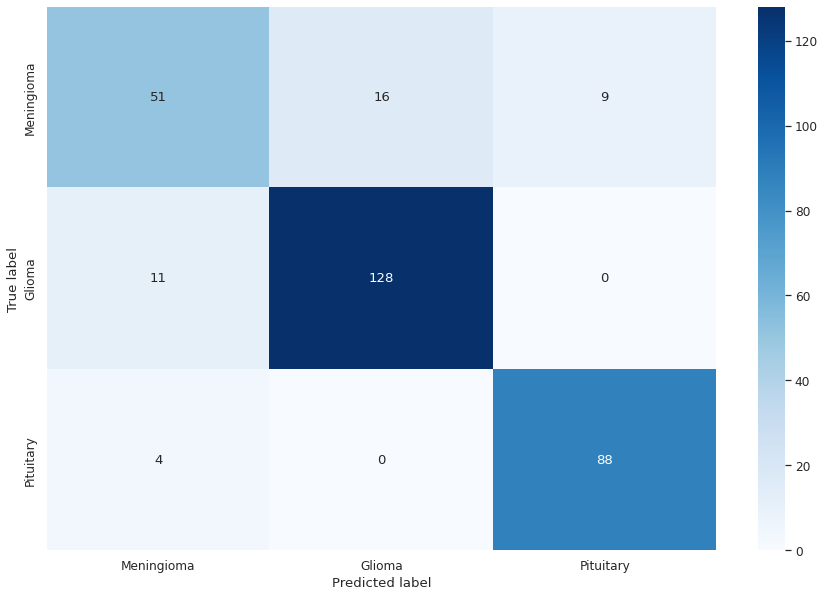

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

def print_confusion_matrix(real,predicted):
    cmap="Blues"
    cm_plot_labels = ['Meningioma','Glioma','Pituitary']
    cm = confusion_matrix(y_true=real, y_pred=predicted)
    df_cm = pd.DataFrame(cm,cm_plot_labels,cm_plot_labels)
    sns.set(font_scale=1.1) # for label size
    plt.figure(figsize = (15,10))
    s=sns.heatmap(df_cm, annot=True,fmt='g',cmap=cmap) # font size
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('confusion_matrix.png')
    plt.show()

print_confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))

In [ ]:
model.save('/content/drive/MyDrive/Collab/DMPA Project/model_inceptionV3.h5')